# TMLE Example Notebook

This notebook demonstrates the issue of using uplift curves without knowing true treatment effect and how to solve it by using TMLE as a proxy of the true treatment effect.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import logging
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
import sys
import warnings
warnings.simplefilter("ignore", UserWarning)

from lightgbm import LGBMRegressor

In [3]:
import causalml

from causalml.dataset import synthetic_data
from causalml.inference.meta import BaseXRegressor, TMLELearner
from causalml.metrics.visualize import *
from causalml.propensity import calibrate

print(causalml.__version__)

0.7.0


/Users/jeong/.conda/envs/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
logger = logging.getLogger('causalml')
logger.setLevel(logging.DEBUG)
plt.style.use('fivethirtyeight')

## Generating Synthetic Data

In [5]:
# Generate synthetic data using mode 1
y, X, treatment, tau, b, e = synthetic_data(mode=1, n=1000000, p=10, sigma=5.)

In [6]:
X_train, X_test, y_train, y_test, e_train, e_test, treatment_train, treatment_test, tau_train, tau_test, b_train, b_test = train_test_split(X, y, e, treatment, tau, b, test_size=0.5, random_state=42)

## Calculating Individual Treatment Effect (ITE/CATE)

In [7]:
# X Learner
learner_x = BaseXRegressor(learner=LGBMRegressor())
learner_x.fit(X=X_train, treatment=treatment_train, y=y_train)
cate_x_test = learner_x.predict(X=X_test, p=e_test, treatment=treatment_test).flatten()

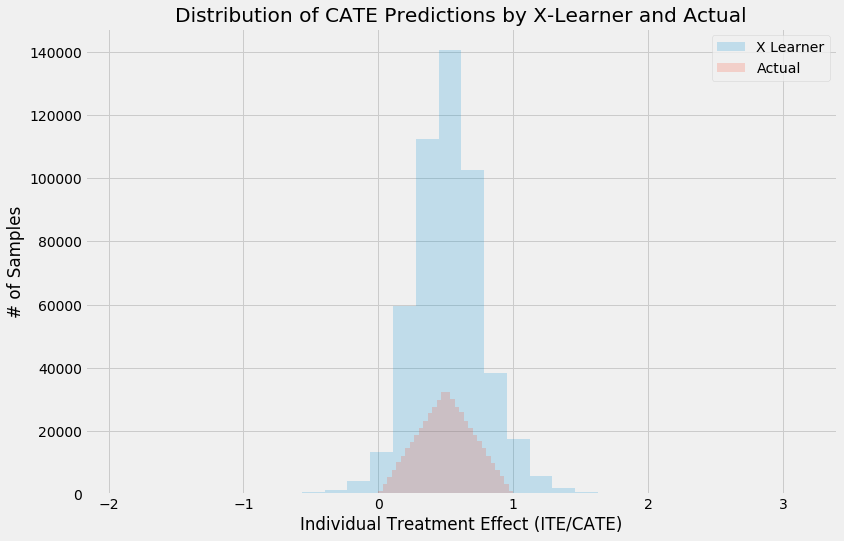

In [8]:
alpha=0.2
bins=30
plt.figure(figsize=(12,8))
plt.hist(cate_x_test, alpha=alpha, bins=bins, label='X Learner')
plt.hist(tau_test, alpha=alpha, bins=bins, label='Actual')

plt.title('Distribution of CATE Predictions by X-Learner and Actual')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')
_=plt.legend()

## Validating CATE without TMLE

In [9]:
df = pd.DataFrame({'y': y_test, 'w': treatment_test, 'tau': tau_test, 'X-Learner': cate_x_test, 'Actual': tau_test})

### Uplift Curve With Ground Truth

If true treatment effect is known as in simulations, the uplift curve of a model uses the cumulative sum of the treatment effect sorted by model's CATE estimate.

In the figure below, the uplift curve of X-learner shows positive lift close to the optimal lift by the ground truth.

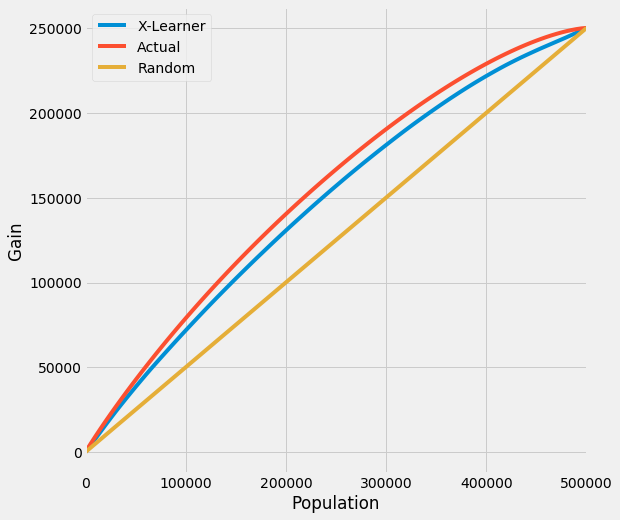

In [10]:
plot(df, outcome_col='y', treatment_col='w', treatment_effect_col='tau')

### Uplift Curve Without Ground Truth

If true treatment effect is unknown as in practice, the uplift curve of a model uses the cumulative mean difference of outcome in the treatment and control group sorted by model's CATE estimate.

In the figure below, the uplift curves of X-learner as well as the ground truth show no lift incorrectly.

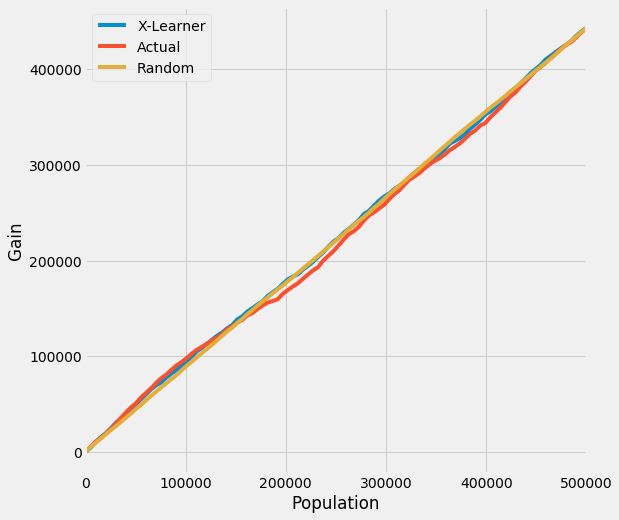

In [11]:
plot(df.drop('tau', axis=1), outcome_col='y', treatment_col='w')

## TMLE 

### Uplift Curve with TMLE as Ground Truth

In [30]:
df = pd.DataFrame({'y': y_test, 'w': treatment_test, 'p': e_test, 'X-Learner': cate_x_test, 'Actual': tau_test})

In [31]:
inference_cols = []
for i in range(X_test.shape[1]):
    col = 'col_' + str(i)
    df[col] = X_test[:,i]
    inference_cols.append(col)

In [32]:
df.head()

,y,w,p,X-Learner,Actual,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9
0,1.515957,0,0.787916,0.762505,0.846151,0.776789,0.915513,0.901576,0.644179,0.468830,0.378331,0.096517,0.250536,0.364408,0.511041
1,6.278509,0,0.420819,0.567534,0.529619,0.152473,0.906765,0.500504,0.389418,0.869202,0.022591,0.942507,0.351105,0.961026,0.987831
2,2.055806,1,0.279077,0.188088,0.323270,0.202957,0.443583,0.687224,0.932249,0.919290,0.108809,0.825424,0.066871,0.815354,0.273419
3,6.356762,1,0.550360,0.652650,0.430953,0.416434,0.445472,0.404358,0.996017,0.026780,0.550151,0.516702,0.496979,0.817935,0.783341
4,1.235313,0,0.454457,0.546827,0.453713,0.217728,0.689698,0.493435,0.303582,0.009072,0.100912,0.587586,0.668540,0.981885,0.286680


In [35]:
tmle_df = get_tmlegain(df, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
                       n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

In [36]:
tmle_df

,X-Learner,Actual,Random
0.0,0.000000,0.000000,0.000000
0.2,0.145887,0.156463,0.103117
0.4,0.257239,0.290165,0.206235
0.6,0.366682,0.387774,0.309352
0.8,0.447900,0.463166,0.412469
1.0,0.515586,0.515586,0.515586


#### Uplift Curve wihtout CI

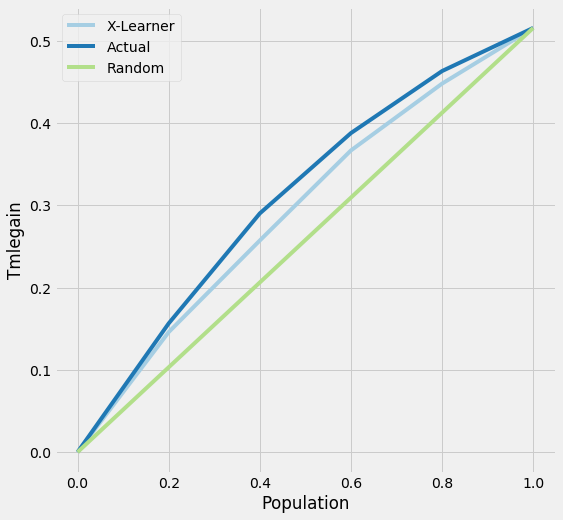

In [59]:
plot_tmlegain(df, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
              n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

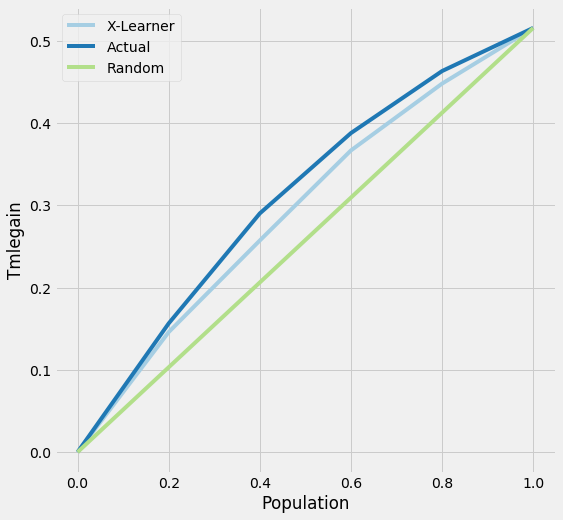

In [60]:
plot(df, kind='tmlegain', inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
     n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

#### AUUC Score

In [61]:
auuc_score_tmle(df, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
                n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

X-Learner    0.288882
Actual       0.302192
Random       0.257793
dtype: float64

#### Uplift Curve with CI

In [62]:
tmle_df = get_tmlegain(df, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
                       n_segment=5, cv=kf, calibrate_propensity=True, ci=True)

In [63]:
tmle_df

,X-Learner,Actual,X-Learner LB,Actual LB,X-Learner UB,Actual UB,Random
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.2,0.145887,0.156463,0.127929,0.137506,0.163845,0.175419,0.103117
0.4,0.257239,0.290165,0.221375,0.253279,0.293102,0.327051,0.206235
0.6,0.366682,0.387774,0.314770,0.336895,0.418593,0.438653,0.309352
0.8,0.447900,0.463166,0.380226,0.397326,0.515574,0.529005,0.412469
1.0,0.515586,0.515586,0.477581,0.477581,0.553592,0.553592,0.515586


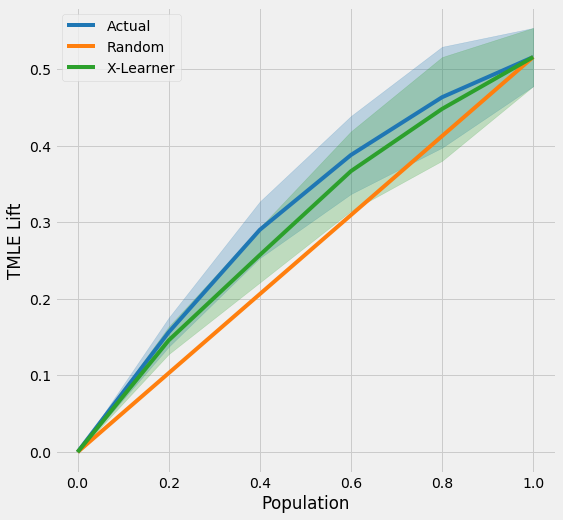

In [64]:
plot_tmlegain(df, learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300),
     inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
     n_segment=5, cv=kf, calibrate_propensity=True, ci=True)

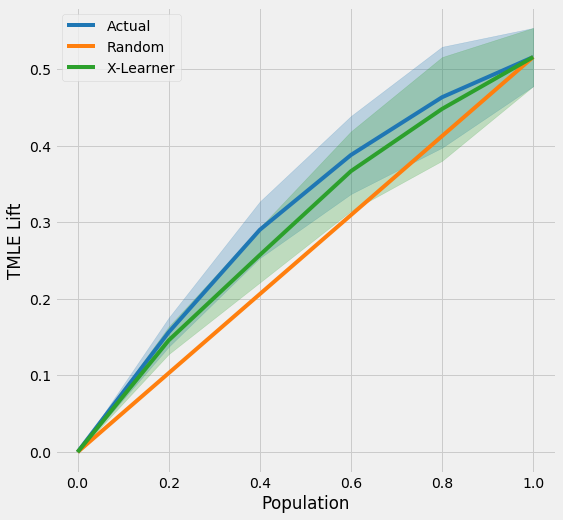

In [65]:
plot(df, kind='tmlegain', learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300),
     inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
     n_segment=5, cv=kf, calibrate_propensity=True, ci=True)

### Qini Curve with TMLE as Ground Truth

#### Qini Curve without CI

In [96]:
qini = get_tmleqini(df, learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300),
                    inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
                    n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

In [97]:
qini

,X-Learner,Actual,Random
0.0,0.000000,0.000000,0.000000
100000.0,50842.376917,63777.326458,26765.734593
200000.0,90452.402088,118561.333061,53531.469187
300000.0,121257.292321,143665.213426,80297.203780
400000.0,137268.660990,155351.330091,107062.938373
500000.0,133828.672967,133828.672967,133828.672967


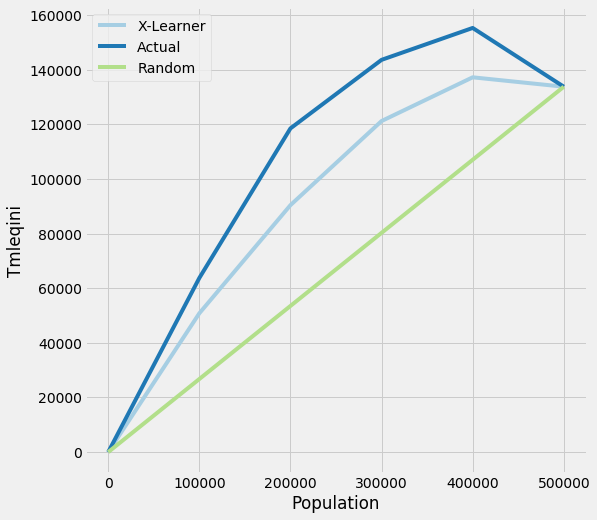

In [98]:
plot_tmleqini(df, learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300),
              inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
              n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

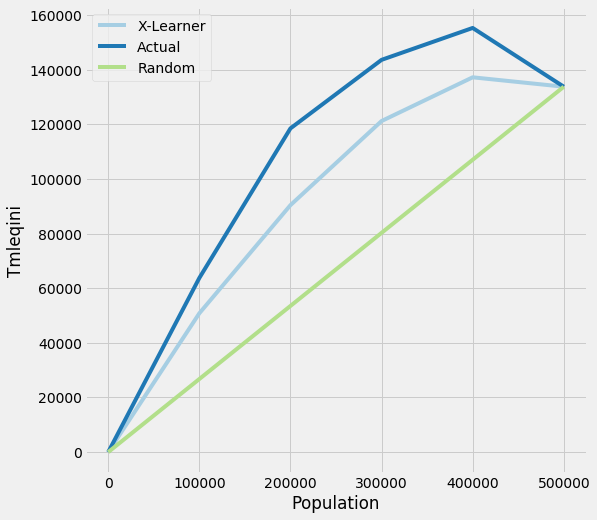

In [99]:
plot(df, kind='tmleqini', learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300),
     inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
     n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

#### Qini Score

In [70]:
qini_score_tmle(df, learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300),
                inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
                n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

X-Learner    22027.231064
Actual       35616.309517
Random           0.000000
dtype: float64

#### Qini Curve with CI

In [92]:
qini = get_tmleqini(df, learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300),
                    inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
                    n_segment=5, cv=kf, calibrate_propensity=True, ci=True)

In [93]:
qini

,X-Learner,Actual,X-Learner LB,Actual LB,X-Learner UB,Actual UB,Random
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
100000.0,50842.376917,63777.326458,44583.855758,56050.317983,57100.898076,71504.334934,26765.734593
200000.0,90452.402088,118561.333061,77824.663158,103487.765480,103080.141019,133634.900642,53531.469187
300000.0,121257.292321,143665.213426,104112.387483,124992.752994,138402.197160,162337.673857,80297.203780
400000.0,137268.660990,155351.330091,117016.377200,134359.992781,157520.944780,176342.667401,107062.938373
500000.0,133828.672967,133828.672967,133828.672967,133828.672967,133828.672967,133828.672967,133828.672967


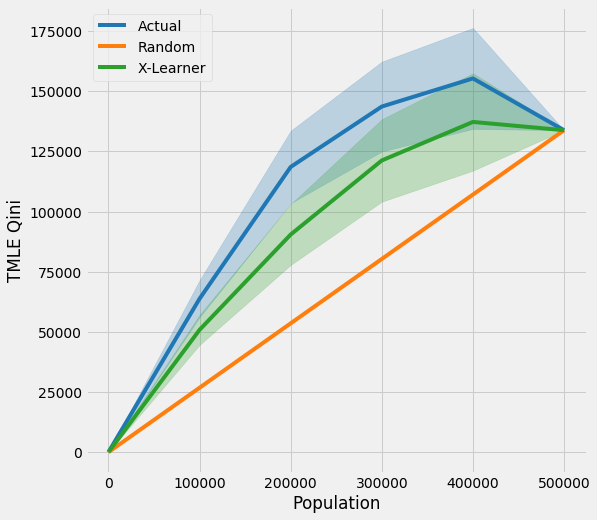

In [94]:
plot_tmleqini(df, learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300),
              inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
              n_segment=5, cv=kf, calibrate_propensity=True, ci=True)

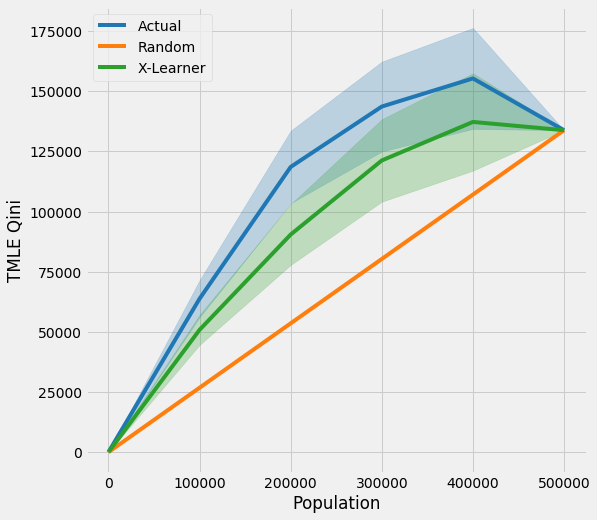

In [95]:
plot(df, kind='tmleqini', learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300),
     inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
     n_segment=5, cv=kf, calibrate_propensity=True, ci=True)